## Description of Notebook

The notebook is used to test ML approach on the VDF statistical momentsa, anisotropies, and particle numbers for species

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

C:\Users\Slava\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Test 1. Some standard classifiers.

In [2]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_moments.npy')
labels_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_labels.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_timep.npy')
print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

The total number of data points is: 854
Among them unstable (positive) samples: 361


In [3]:
scaler = StandardScaler()
scaler.fit(featurevector_allmoments)
featurevector_allmoments = scaler.transform(featurevector_allmoments)

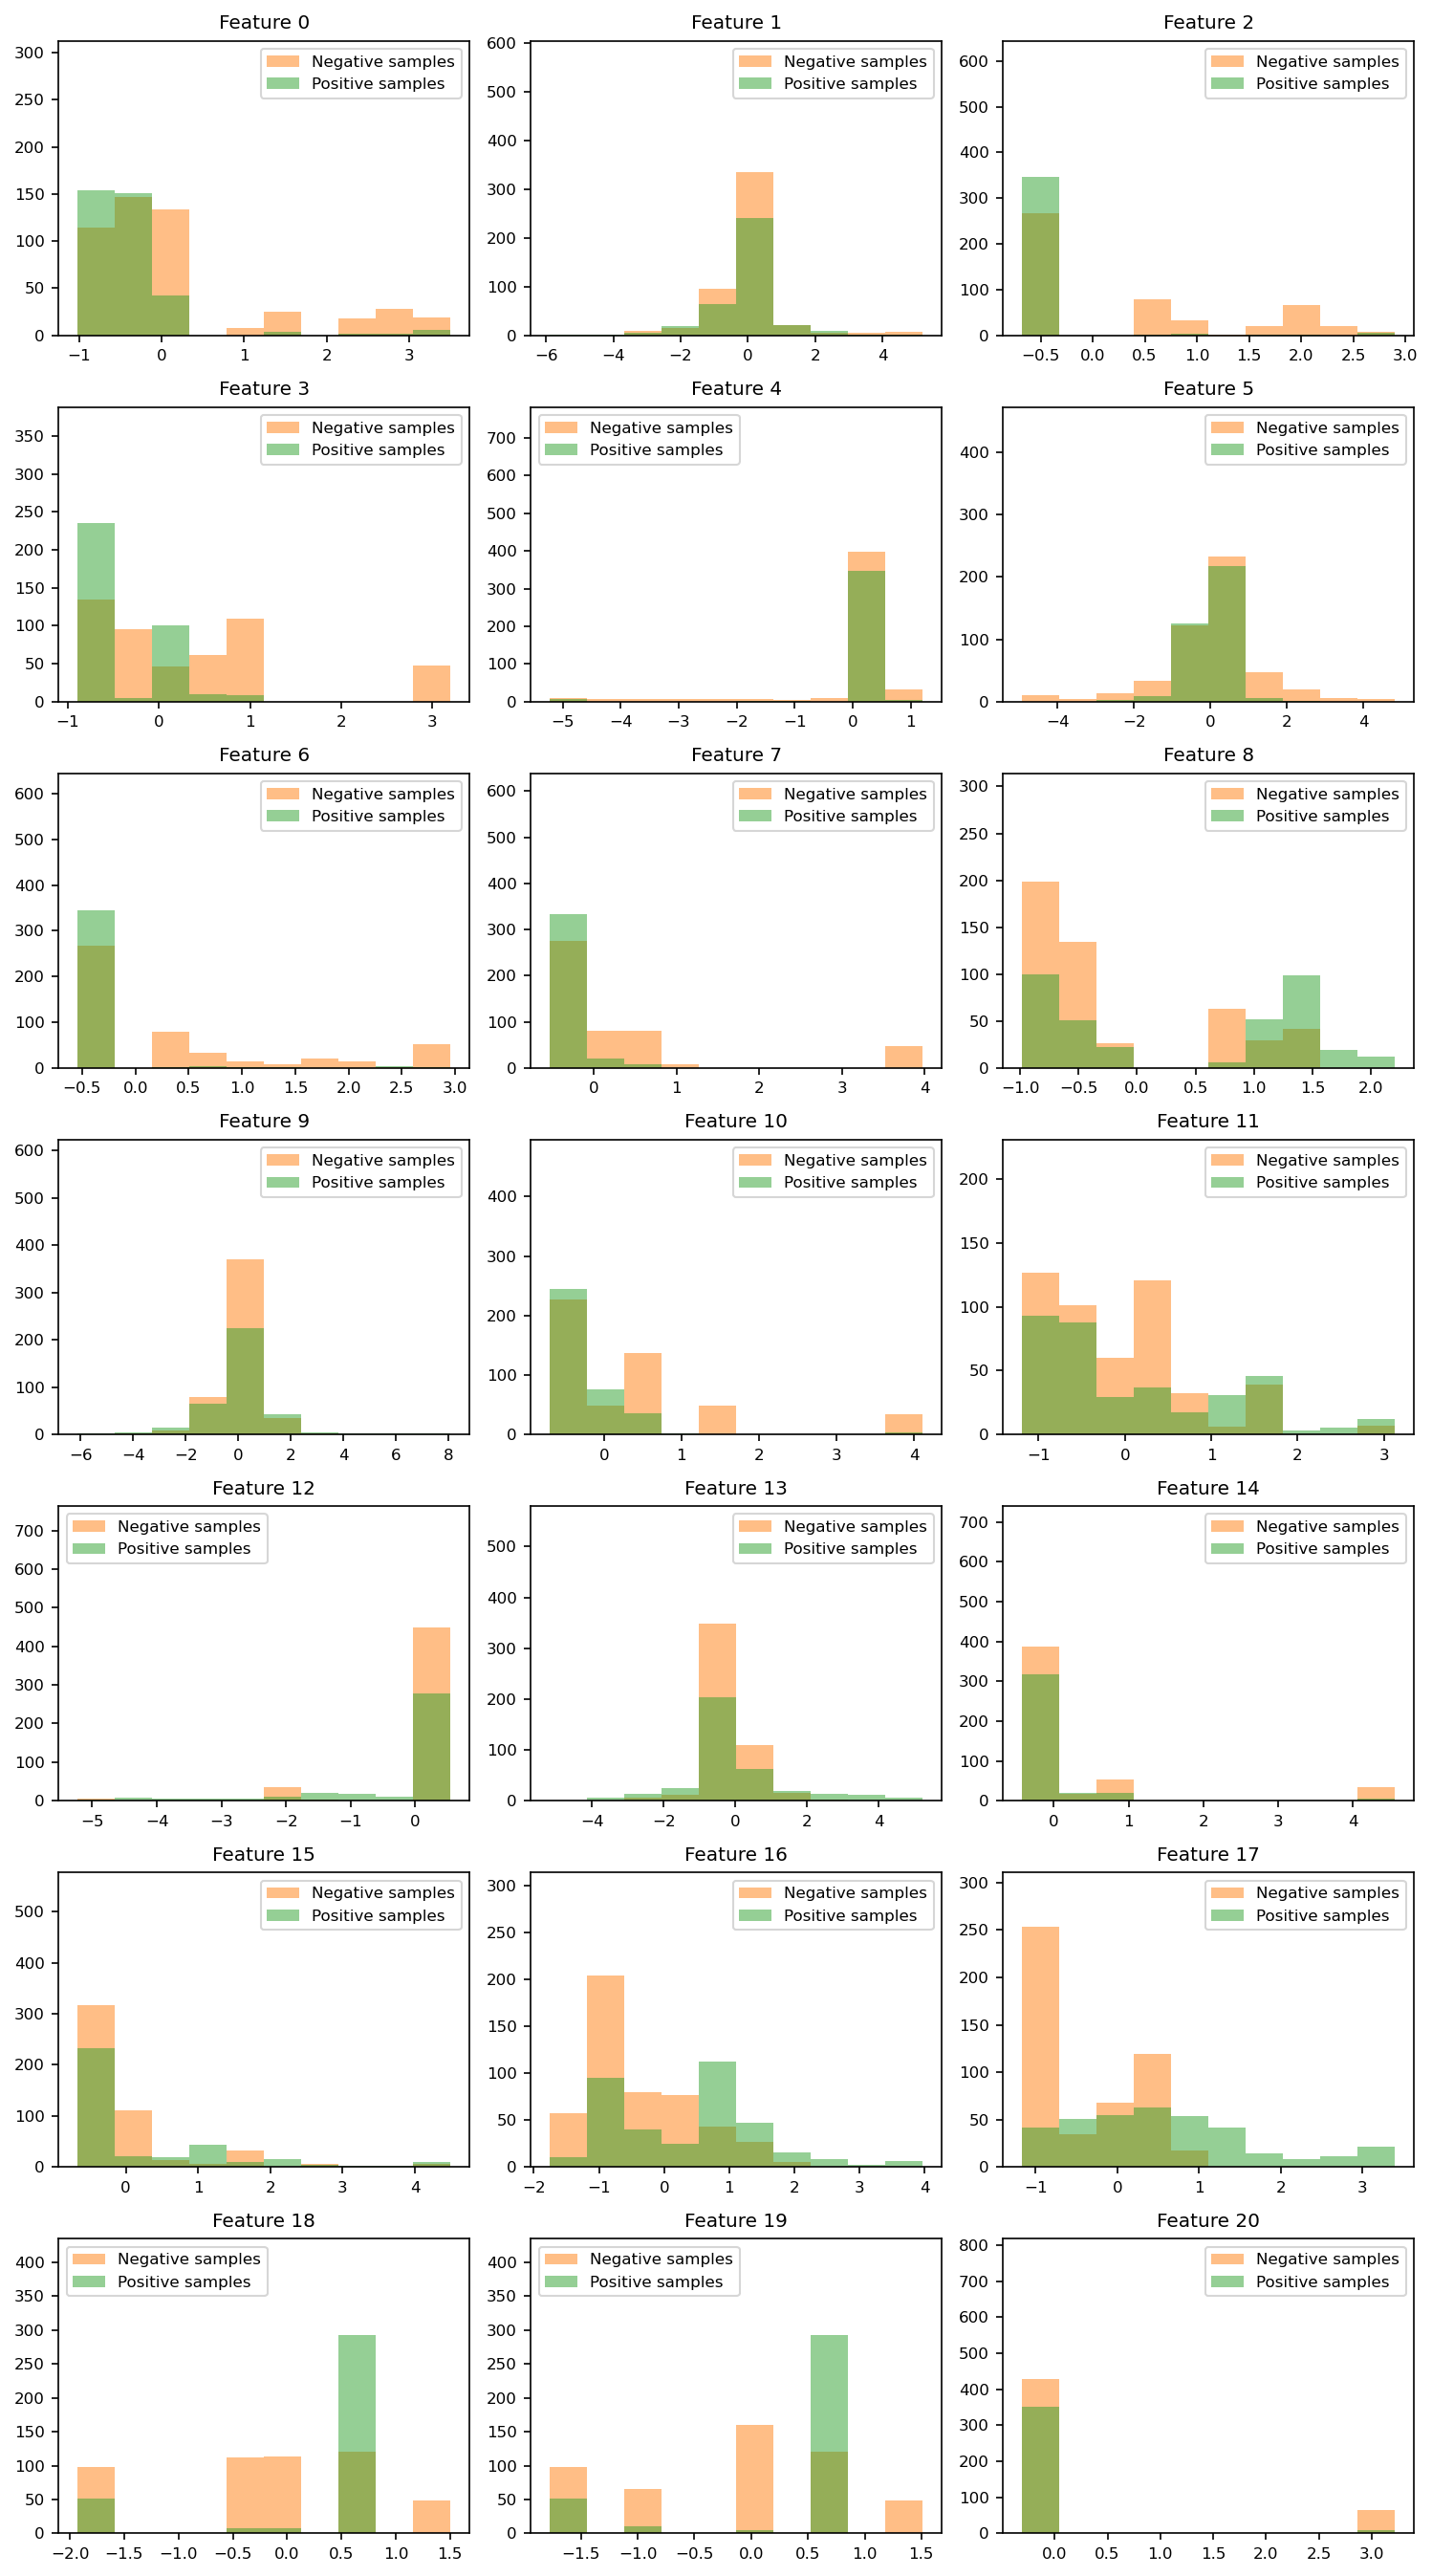

In [4]:
index_0 = np.where(labels_allmoments == 0)[0]
index_1 = np.where(labels_allmoments == 1)[0]

matplotlib.rcParams.update({'font.size':8})
im, ax = plt.subplots(7, 3, figsize = (10, 18), dpi=150)
for i in range (0, 7, 1):
    for j in range (0, 3, 1):
        hist, bins, patches = ax[i,j].hist(featurevector_allmoments[:,i*3+j], bins=10, alpha=0.00)
        ax[i,j].hist(featurevector_allmoments[index_0,i*3+j], bins=bins, label='Negative samples', alpha=0.50)
        ax[i,j].hist(featurevector_allmoments[index_1,i*3+j], bins=bins, label='Positive samples', alpha=0.50)
        ax[i,j].set(title='Feature '+str(i*3+j))
        ax[i,j].legend()

plt.tight_layout()
plt.show()

In [13]:
def outputclass_analysis(test_labels, predicted_labels, output_score=''):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    print("------------ SUMMARY OF CLASSIFICATION RESULTS ----------------")
    print("TP = "+str(tp))
    print("TN = "+str(tn))
    print("FP = "+str(fp))
    print("FN = "+str(fn))
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    print("Precision = "+str(precision))
    print("Recall = "+str(recall))
    print("Accuracy = "+str(acc))
    print("TSS = "+str(tss))
    print("HSS = "+str(hss))
    if (output_score == 'TSS'): return tss
    if (output_score == 'HSS'): return hss
    if (output_score == 'precision'): return precision
    if (output_score == 'accuracy'): return acc
    return

In [6]:
X_train, X_test, f_train, f_test = train_test_split(featurevector_allmoments, labels_allmoments, test_size=0.33, random_state=1)

K-Nearest Neighbor approach (see n_neighbors = 1 case, which is very interesting)

In [7]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, f_train)
f_predicted = clf.predict(X_test)
outputclass_analysis(f_test, f_predicted)

------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 96
TN = 162
FP = 3
FN = 21
Precision = 0.9696969696969697
Recall = 0.8205128205128205
Accuracy = 0.9148936170212766
TSS = 0.8023310023310023
HSS = 0.8206962327134001


An SVM with the weight balancing setup

In [8]:
clf = SVC(kernel='rbf', class_weight='balanced')
clf.fit(X_train, f_train)
f_predicted = clf.predict(X_test)
outputclass_analysis(f_test, f_predicted)

------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 100
TN = 150
FP = 15
FN = 17
Precision = 0.8695652173913043
Recall = 0.8547008547008547
Accuracy = 0.8865248226950354
TSS = 0.7637917637917637
HSS = 0.7656955912135847


A very simple neural network with the hidden layer size of 50

In [10]:
clf = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=10000, tol=1e-6)
clf.fit(X_train, f_train)
f_predicted = clf.predict(X_test)
outputclass_analysis(f_test, f_predicted)

------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 109
TN = 161
FP = 4
FN = 8
Precision = 0.9646017699115044
Recall = 0.9316239316239316
Accuracy = 0.9574468085106383
TSS = 0.9073815073815074
HSS = 0.911916289239419


## Test 2. Separation into chunks of data.

In [11]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_moments.npy')
labels_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_labels.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_timep.npy')
print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

The total number of data points is: 854
Among them unstable (positive) samples: 361


In [12]:
scaler = StandardScaler()
scaler.fit(featurevector_allmoments)
featurevector_allmoments = scaler.transform(featurevector_allmoments)

In [21]:
def separate_chunksizebased(featurevector_allmoments, labels_allmoments, chunksize):

    X_train = []
    X_test = []
    f_train = []
    f_test = []

    mode = 'train'
    for i in range (0, len(labels_allmoments), chunksize):
        _chunksize = chunksize
        if (i + chunksize > len(labels_allmoments)): _chunksize = len(labels_allmoments) - i
        if (mode == 'train'):
            for j in range (0, _chunksize, 1):
                X_train.append(featurevector_allmoments[i+j,:])
                f_train.append(labels_allmoments[i+j])
            mode = 'test'
            continue
        if (mode == 'test'):
            for j in range (0, _chunksize, 1):
                X_test.append(featurevector_allmoments[i+j,:])
                f_test.append(labels_allmoments[i+j])
            mode = 'train'
            continue

    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)
    f_train = np.array(f_train, dtype=float)
    f_test = np.array(f_test, dtype=float)
    
    print("The size of the chunk:", chunksize)
    print("Number of positive - negative samples in train: " + str(np.sum(f_train)) + " --- " + str(len(f_train)-np.sum(f_train)))
    print("Number of positive - negative samples in test: " + str(np.sum(f_test)) + " --- " + str(len(f_test)-np.sum(f_test)))
    
    return X_train, X_test, f_train, f_test

output_scores = []
chunksizes = np.arange(2, 102, 2)

for chunksize in chunksizes:
    X_train, X_test, f_train, f_test = separate_chunksizebased(featurevector_allmoments, labels_allmoments, chunksize)
    clf = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=10000)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    output_scores.append(outputclass_analysis(f_test, f_predicted, output_score='accuracy'))

The size of the chunk: 2
Number of positive - negative samples in train: 181.0 --- 247.0
Number of positive - negative samples in test: 180.0 --- 246.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 158
TN = 232
FP = 14
FN = 22
Precision = 0.9186046511627907
Recall = 0.8777777777777778
Accuracy = 0.9154929577464789
TSS = 0.8208672086720867
HSS = 0.8257906215921483
The size of the chunk: 4
Number of positive - negative samples in train: 188.0 --- 240.0
Number of positive - negative samples in test: 173.0 --- 253.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 157
TN = 232
FP = 21
FN = 16
Precision = 0.8820224719101124
Recall = 0.9075144508670521
Accuracy = 0.9131455399061033
TSS = 0.8245104982978821
HSS = 0.8207600809661353
The size of the chunk: 6
Number of positive - negative samples in train: 171.0 --- 257.0
Number of positive - negative samples in test: 190.0 --- 236.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 1

------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 131
TN = 173
FP = 70
FN = 40
Precision = 0.6517412935323383
Recall = 0.7660818713450293
Accuracy = 0.7342995169082126
TSS = 0.47801602772363005
HSS = 0.4659066919991556
The size of the chunk: 46
Number of positive - negative samples in train: 196.0 --- 244.0
Number of positive - negative samples in test: 165.0 --- 249.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 94
TN = 179
FP = 70
FN = 71
Precision = 0.573170731707317
Recall = 0.5696969696969697
Accuracy = 0.6594202898550725
TSS = 0.28857247170500183
HSS = 0.288867772823624
The size of the chunk: 48
Number of positive - negative samples in train: 163.0 --- 269.0
Number of positive - negative samples in test: 198.0 --- 224.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 138
TN = 190
FP = 34
FN = 60
Precision = 0.8023255813953488
Recall = 0.696969696969697
Accuracy = 0.7772511848341233
TSS = 0.5451839826839827
HSS = 0.54

------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 79
TN = 172
FP = 76
FN = 87
Precision = 0.5096774193548387
Recall = 0.4759036144578313
Accuracy = 0.606280193236715
TSS = 0.1694520015546055
HSS = 0.17132892894859642
The size of the chunk: 90
Number of positive - negative samples in train: 195.0 --- 255.0
Number of positive - negative samples in test: 166.0 --- 238.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 98
TN = 175
FP = 63
FN = 68
Precision = 0.6086956521739131
Recall = 0.5903614457831325
Accuracy = 0.6757425742574258
TSS = 0.32565556343019136
HSS = 0.3271460537021969
The size of the chunk: 92
Number of positive - negative samples in train: 206.0 --- 254.0
Number of positive - negative samples in test: 155.0 --- 239.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 118
TN = 128
FP = 111
FN = 37
Precision = 0.5152838427947598
Recall = 0.7612903225806451
Accuracy = 0.6243654822335025
TSS = 0.29685517613713047
HSS = 0

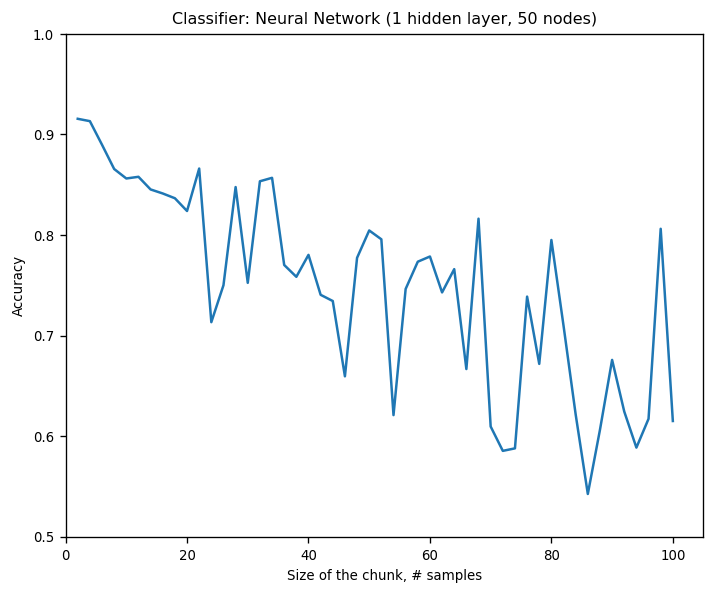

In [24]:
im, ax = plt.subplots(1, 1, figsize=(6,5), dpi=120)
ax.plot(chunksizes, output_scores)
ax.set(xlim=[0.0,105.0], ylim=[0.5,1.0], xlabel='Size of the chunk, # samples', ylabel='Accuracy', \
       title='Classifier: Neural Network (1 hidden layer, 50 nodes)')
plt.tight_layout()
plt.show()

In [25]:
def separate_chunksizebased(featurevector_allmoments, labels_allmoments, chunksize):

    X_train = []
    X_test = []
    f_train = []
    f_test = []

    mode = 'train'
    for i in range (0, len(labels_allmoments), chunksize):
        _chunksize = chunksize
        if (i + chunksize > len(labels_allmoments)): _chunksize = len(labels_allmoments) - i
        if (mode == 'train'):
            for j in range (0, _chunksize, 1):
                X_train.append(featurevector_allmoments[i+j,:])
                f_train.append(labels_allmoments[i+j])
            mode = 'test'
            continue
        if (mode == 'test'):
            for j in range (0, _chunksize, 1):
                X_test.append(featurevector_allmoments[i+j,:])
                f_test.append(labels_allmoments[i+j])
            mode = 'train'
            continue

    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)
    f_train = np.array(f_train, dtype=float)
    f_test = np.array(f_test, dtype=float)
    
    print("The size of the chunk:", chunksize)
    print("Number of positive - negative samples in train: " + str(np.sum(f_train)) + " --- " + str(len(f_train)-np.sum(f_train)))
    print("Number of positive - negative samples in test: " + str(np.sum(f_test)) + " --- " + str(len(f_test)-np.sum(f_test)))
    
    return X_train, X_test, f_train, f_test

output_scores = []
chunksizes = np.arange(2, 102, 2)

for chunksize in chunksizes:
    X_train, X_test, f_train, f_test = separate_chunksizebased(featurevector_allmoments, labels_allmoments, chunksize)
    clf = SVC(kernel='rbf', class_weight='balanced')
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    output_scores.append(outputclass_analysis(f_test, f_predicted, output_score='accuracy'))

The size of the chunk: 2
Number of positive - negative samples in train: 181.0 --- 247.0
Number of positive - negative samples in test: 180.0 --- 246.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 157
TN = 206
FP = 40
FN = 23
Precision = 0.7969543147208121
Recall = 0.8722222222222222
Accuracy = 0.852112676056338
TSS = 0.7096205962059621
HSS = 0.700742623937914
The size of the chunk: 4
Number of positive - negative samples in train: 188.0 --- 240.0
Number of positive - negative samples in test: 173.0 --- 253.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 155
TN = 221
FP = 32
FN = 18
Precision = 0.8288770053475936
Recall = 0.8959537572254336
Accuracy = 0.8826291079812206
TSS = 0.7694715437866984
HSS = 0.759750953100679
The size of the chunk: 6
Number of positive - negative samples in train: 171.0 --- 257.0
Number of positive - negative samples in test: 190.0 --- 236.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 164


The size of the chunk: 52
Number of positive - negative samples in train: 214.0 --- 224.0
Number of positive - negative samples in test: 147.0 --- 269.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 91
TN = 163
FP = 106
FN = 56
Precision = 0.4619289340101523
Recall = 0.6190476190476191
Accuracy = 0.6105769230769231
TSS = 0.22499557443795365
HSS = 0.20888408893480148
The size of the chunk: 54
Number of positive - negative samples in train: 181.0 --- 251.0
Number of positive - negative samples in test: 180.0 --- 242.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 92
TN = 192
FP = 50
FN = 88
Precision = 0.647887323943662
Recall = 0.5111111111111111
Accuracy = 0.6729857819905213
TSS = 0.3044995408631772
HSS = 0.31296305035156435
The size of the chunk: 56
Number of positive - negative samples in train: 158.0 --- 290.0
Number of positive - negative samples in test: 203.0 --- 203.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP

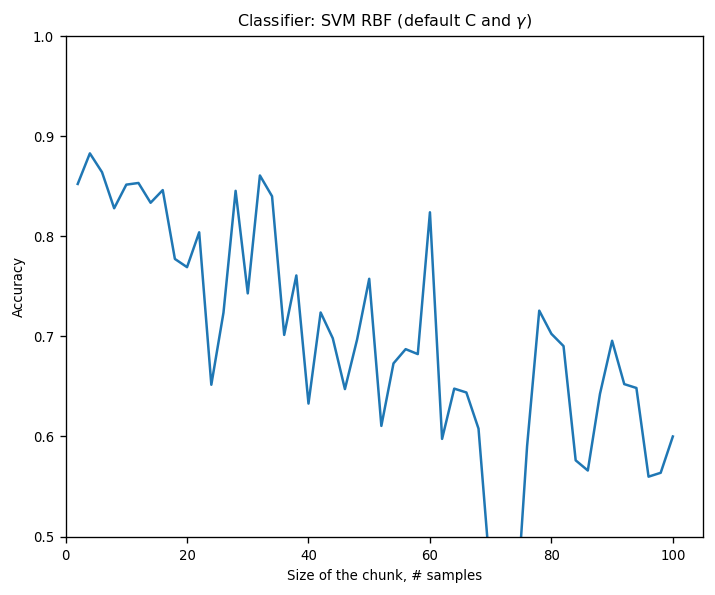

In [26]:
im, ax = plt.subplots(1, 1, figsize=(6,5), dpi=120)
ax.plot(chunksizes, output_scores)
ax.set(xlim=[0.0,105.0], ylim=[0.5,1.0], xlabel='Size of the chunk, # samples', ylabel='Accuracy', \
       title=r'Classifier: SVM RBF (default C and $\gamma$)')
plt.tight_layout()
plt.show()

In [ ]:
def separate_chunksizebased(featurevector_allmoments, labels_allmoments, chunksize):

    X_train = []
    X_test = []
    f_train = []
    f_test = []

    mode = 'train'
    for i in range (0, len(labels_allmoments), chunksize):
        _chunksize = chunksize
        if (i + chunksize > len(labels_allmoments)): _chunksize = len(labels_allmoments) - i
        if (mode == 'train'):
            for j in range (0, _chunksize, 1):
                X_train.append(featurevector_allmoments[i+j,:])
                f_train.append(labels_allmoments[i+j])
            mode = 'test'
            continue
        if (mode == 'test'):
            for j in range (0, _chunksize, 1):
                X_test.append(featurevector_allmoments[i+j,:])
                f_test.append(labels_allmoments[i+j])
            mode = 'train'
            continue

    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)
    f_train = np.array(f_train, dtype=float)
    f_test = np.array(f_test, dtype=float)
    
    print("The size of the chunk:", chunksize)
    print("Number of positive - negative samples in train: " + str(np.sum(f_train)) + " --- " + str(len(f_train)-np.sum(f_train)))
    print("Number of positive - negative samples in test: " + str(np.sum(f_test)) + " --- " + str(len(f_test)-np.sum(f_test)))
    
    return X_train, X_test, f_train, f_test

output_scores = []
chunksizes = np.arange(2, 102, 2)

for chunksize in chunksizes:
    X_train, X_test, f_train, f_test = separate_chunksizebased(featurevector_allmoments, labels_allmoments, chunksize)
    clf = SVC(kernel='rbf', class_weight='balanced')
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    output_scores.append(outputclass_analysis(f_test, f_predicted, output_score='accuracy'))